## Imports

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy import constants
from scipy.optimize import leastsq
from lmfit import minimize, Parameters, report_fit
%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 10)
pd.options.mode.chained_assignment = None  # default='warn'

## Sort Data

In [214]:
k = constants.value('Boltzmann constant in eV/K')
e = np.exp(1)

GRDF = pd.read_csv("../Data/GrowthRespPhotoData_new.csv",
                   usecols = ["FinalID",
                              "StandardisedTraitName",
                              "StandardisedTraitDef",
                              "StandardisedTraitValue",
                              "StandardisedTraitUnit",
                              "AmbientTemp",
                              "AmbientTempUnit",
                              "ConTemp",
                              "ConTempUnit",
                              "ResTemp",
                              "ResTempUnit"],
                   low_memory = False)

# get rid of 0s -ves and NAs from data (only +ves)
GRDF = GRDF.iloc[GRDF.index[GRDF["StandardisedTraitValue"] > 0]]

# get rid of ids with < 5 data points
GRDF = GRDF.groupby("FinalID").filter(lambda x: len(x) > 5)

# set NewID based on OriginalID **do i even need to do this?**
GRDF["NewID"] = GRDF.FinalID.astype("category").cat.codes


# convert to kelvin
GRDF.ConTempUnit     = GRDF.ConTempUnit.str.lower()
GRDF.AmbientTempUnit = GRDF.AmbientTempUnit.str.lower()
GRDF.ResTempUnit     = GRDF.ResTempUnit.str.lower()

GRDF.ConTemp[GRDF.ConTempUnit != "kelvin"]         = GRDF.ConTemp[GRDF.ConTempUnit != "kelvin"] + 273.15
GRDF.AmbientTemp[GRDF.AmbientTempUnit != "kelvin"] = GRDF.AmbientTemp[GRDF.AmbientTempUnit != "kelvin"] + 273.15
GRDF.ResTemp[GRDF.ResTempUnit != "kelvin"]         = GRDF.ResTemp[GRDF.ResTempUnit != "kelvin"] + 273.15


# only columns i need
GRDF = GRDF.loc[ : ,("NewID",
                     "FinalID",
                     "StandardisedTraitName",
                     "StandardisedTraitDef",
                     "StandardisedTraitValue",
                     "StandardisedTraitUnit",
                     "AmbientTemp",
                     "ConTemp",
                     "ResTemp")]

# logged trait value
GRDF["STVlogged"] = np.log(GRDF.StandardisedTraitValue)

## Choose a Curve

<function matplotlib.pyplot.show>

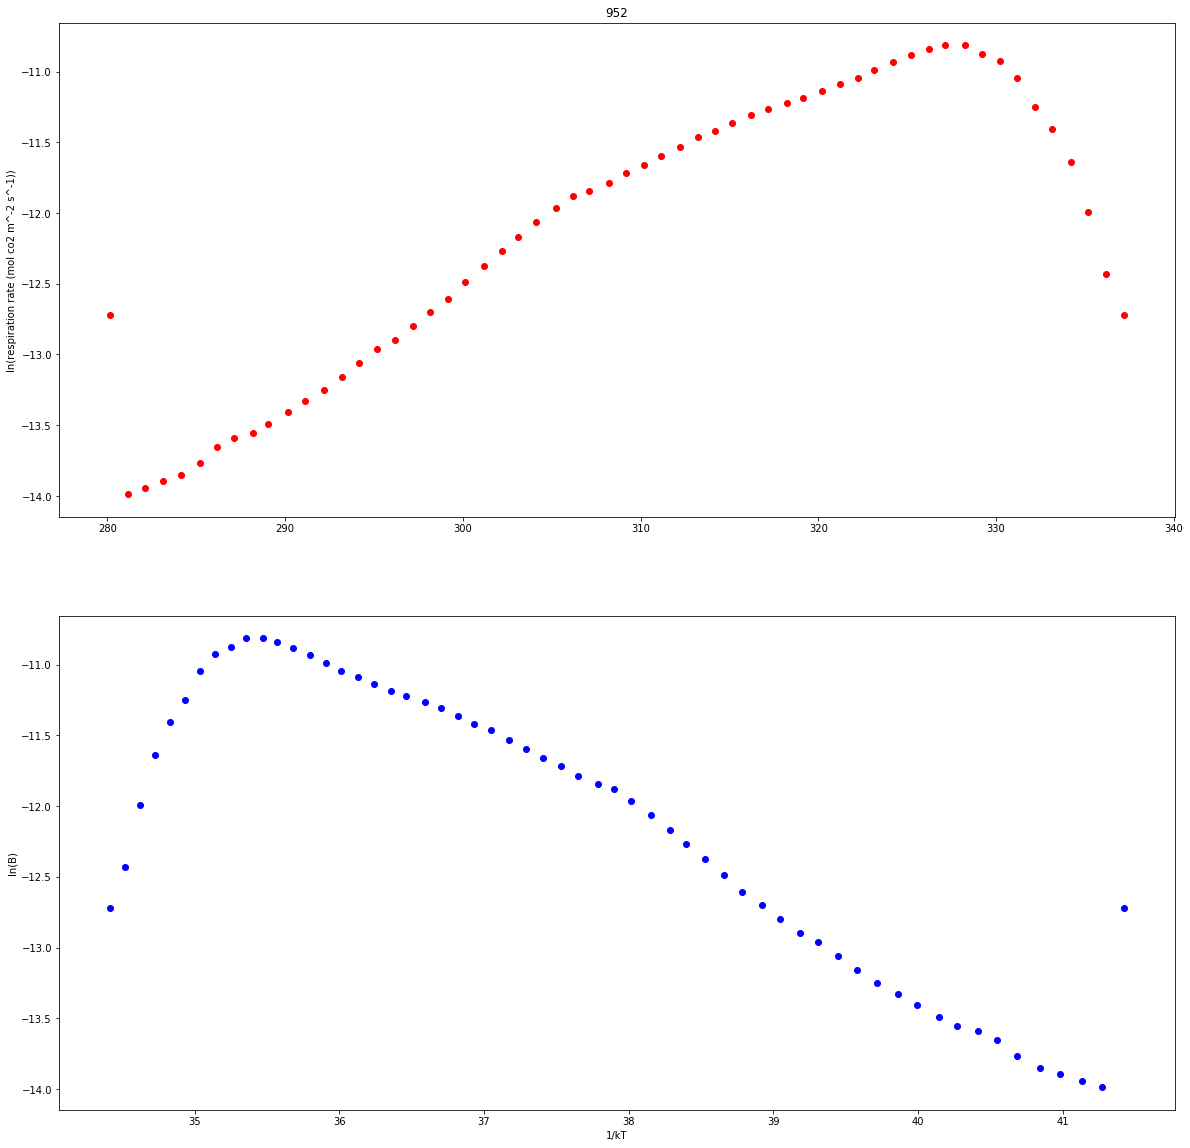

In [215]:
id = 952

curveDF = GRDF[GRDF["NewID"] == id]

if curveDF["ConTemp"].isnull().any() == False:
    curveDF = curveDF.sort_values("ConTemp")
    xVals   = np.asarray(curveDF["ConTemp"])
elif curveDF["AmbientTemp"].isnull().any() == False:
    curveDF = curveDF.sort_values("AmbientTemp")
    xVals   = np.asarray(curveDF["AmbientTemp"])
elif curveDF["ResTemp"].isnull().any() == False:
    curveDF = curveDF.sort_values("ResTemp")
    xVals   = np.asarray(curveDF["ResTemp"])

data    = np.asarray(curveDF["StandardisedTraitValue"])
ldata   = np.asarray(curveDF["STVlogged"])

ytitle = ("ln(" + curveDF["StandardisedTraitName"].iloc[0] + " (" +
          curveDF["StandardisedTraitUnit"].iloc[0] + "))")


plt.figure(figsize = (20, 20))
plt.subplot(211)
plt.plot(xVals, ldata, 'ro')
plt.ylabel(ytitle)
plt.title(id)

plt.subplot(212)
plt.plot((1/(xVals*k)), ldata, 'bo')
plt.xlabel("1/kT")
plt.ylabel("ln(B)")



plt.show

## General cubic polynomial model

$$ \large B = B_0 + B_1T + B_2T^2 + B_3T^3 $$

[[Fit Statistics]]
    # function evals   = 58
    # data points      = 58
    # variables        = 4
    chi-square         = 2.416
    reduced chi-square = 0.045
    Akaike info crit   = -176.350
    Bayesian info crit = -168.108
[[Variables]]
    a:   2399.23849 +/- 220.3576 (9.18%) (init= 0)
    b:  -24.0772534 +/- 2.147940 (8.92%) (init= 0)
    c:   0.07978532 +/- 0.006968 (8.73%) (init= 0)
    d:  -8.7753e-05 +/- 7.52e-06 (8.57%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(c, d)                      = -1.000 
    C(b, c)                      = -1.000 
    C(a, b)                      = -1.000 
    C(b, d)                      =  0.999 
    C(a, c)                      =  0.999 
    C(a, d)                      = -0.999 


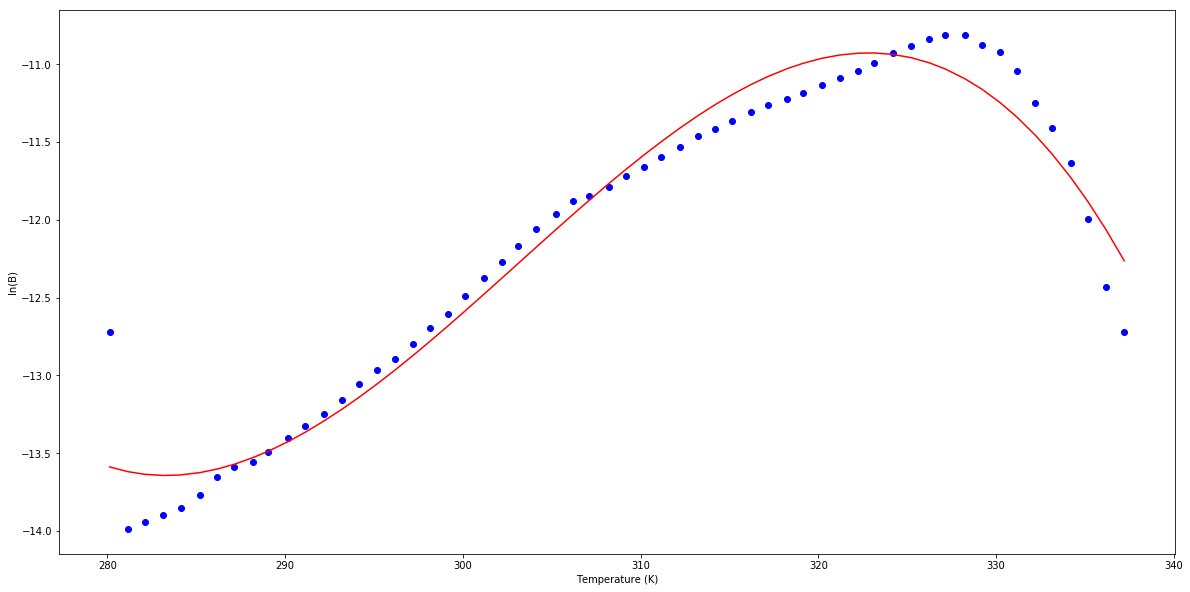

In [216]:
params = Parameters()
params.add('a', value = 0.)
params.add('b', value = 0.)
params.add('c', value = 0.)
params.add('d', value = 0.)

def get_residual(params, x, data):
    a = params['a'].value 
    b = params['b'].value
    c = params['c'].value 
    d = params['d'].value 
    
    model = a + b*x + c*x**2 + d*x**3
    
    return model - data

out1 = minimize(get_residual, params, args = (xVals, ldata))

report_fit(out1)

plt.plot(xVals, ldata, 'bo')
plt.plot(xVals, get_residual(out1.params, xVals, ldata) + ldata, 'r')
plt.xlabel("Temperature (K)")
plt.ylabel("ln(B)")
plt.show()

## Schoolfield Model

$$ \large B = \frac{B_0e^{\frac{-E}{k}(\frac{1}{T} - \frac{1}{283.15})}}{1 + e^{\frac{-E_l}{k}(\frac{1}{T_l}-\frac{1}{T})} + e^{\frac{-E_h}{k}(\frac{1}{T_h}-\frac{1}{T})}} $$

[[Fit Statistics]]
    # function evals   = 14003
    # data points      = 58
    # variables        = 6
    chi-square         = 78.403
    reduced chi-square = 1.508
    Akaike info crit   = 29.482
    Bayesian info crit = 41.845
[[Variables]]
    B0:  -64.6951483 +/- 33.43965 (51.69%) (init= 10)
    E:    3.02188618 +/- 1.240686 (41.06%) (init= 20)
    El:   2.97089637 +/- 1.92e+04 (645828.54%) (init= 10)
    Eh:   3.07928944 +/- 12.13433 (394.06%) (init= 25)
    Tl:   297.090911 +/- 4.46e+06 (1501919.61%) (init= 290)
    Th:   279.899799 +/- 2.40e+03 (858.77%) (init= 290)
    e:    2.718282 (fixed)
    k:    8.61733e-05 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(Tl, Th)                    = -1.000 
    C(El, Th)                    = -1.000 
    C(El, Tl)                    =  1.000 
    C(El, Eh)                    =  0.997 
    C(Eh, Th)                    = -0.996 
    C(Eh, Tl)                    =  0.996 
    C(B0, E)                     = -0.886 
   

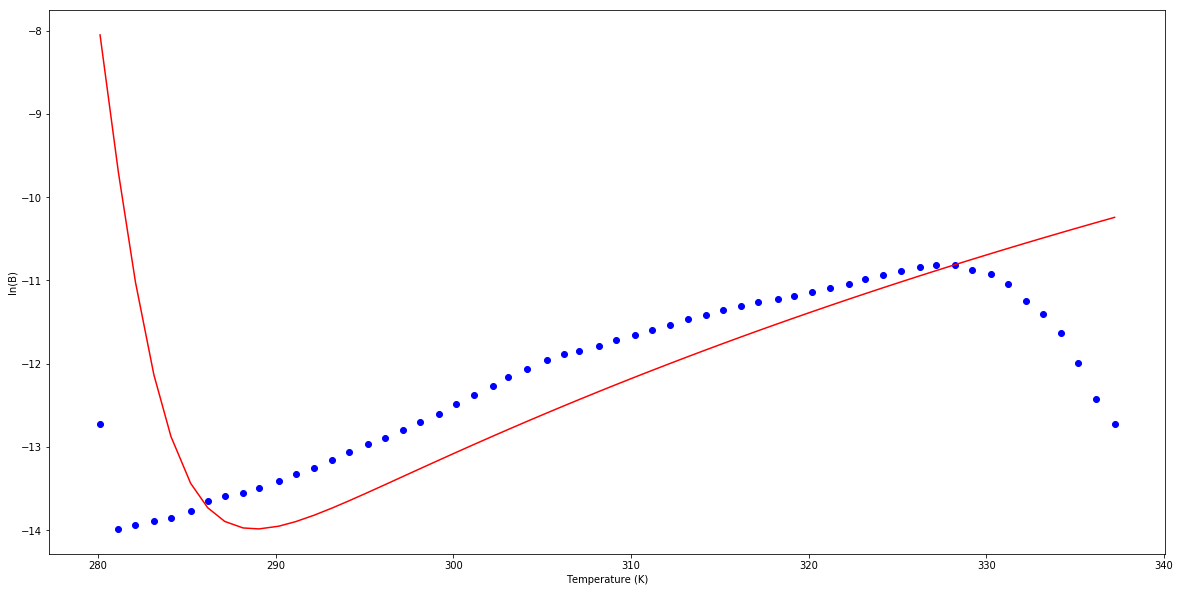

In [223]:
sparams = Parameters()
sparams.add('B0', value = 10)
sparams.add('E',  value = 20)
sparams.add('El', value = 10)
sparams.add('Eh', value = 25)
sparams.add('Tl', value = 290, min = 260, max = 330)
sparams.add('Th', value = 290, min = 260, max = 330)
sparams.add('e',  value = e, vary = False)
sparams.add('k',  value = k, vary = False)

def schlfld_residual(sparams, x, data):
    B0 = sparams['B0'].value 
    E  = sparams['E'].value 
    El = sparams['El'].value 
    Eh = sparams['Eh'].value
    Tl = sparams['Tl'].value
    Th = sparams['Th'].value
    e  = sparams['e'].value
    k  = sparams['k'].value
    
    model = (B0*e**((-E/k)*((1/x)-(1/283.15))))/(1+e**((El/k)*((1/Tl)-(1/x)))+(e**((Eh/k)*((1/Th)-(1/x)))))
        
    return model - data


out2 = minimize(schlfld_residual, sparams, args = (xVals, ldata))

report_fit(out2)

plt.plot(xVals, ldata, 'bo')
plt.plot(xVals, schlfld_residual(out2.params, xVals, ldata) + ldata, 'r')
plt.xlabel("Temperature (K)")
plt.ylabel("ln(B)")
plt.show()

[[Fit Statistics]]
    # function evals   = 89
    # data points      = 58
    # variables        = 5
    chi-square         = 8.248
    reduced chi-square = 0.156
    Akaike info crit   = -103.130
    Bayesian info crit = -92.828
[[Variables]]
    A0:   1.0000e-05 +/- 0        (0.00%) (init= 1e-05)
    Eb:   2.4078e-05 +/- 0        (0.00%) (init= 1e-05)
    Ec:   2.7912e-07 +/- 0        (0.00%) (init= 1e-05)
    Eh:  -5.6722e-05 +/- 0        (0.00%) (init= 1e-05)
    Tm:   320.625139 +/- 0        (0.00%) (init= 290)
    e:    2.718282 (fixed)
    k:    8.61733e-05 (fixed)


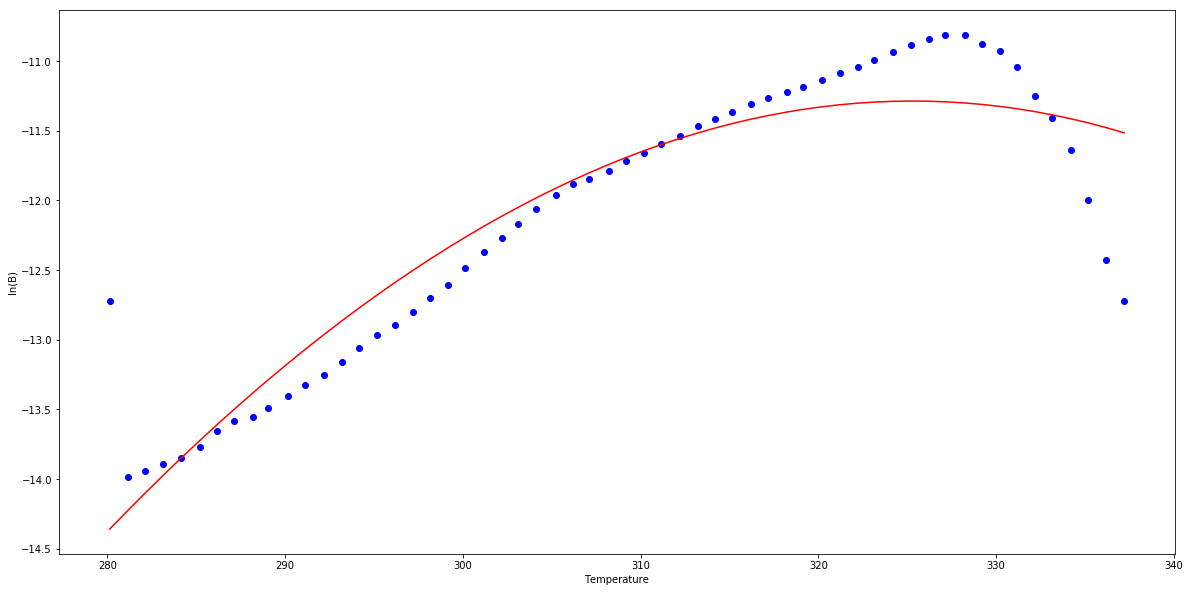

In [221]:
aparams = Parameters()
aparams.add('A0', value = 0.00001)
aparams.add('Eb', value = 0.00001)
aparams.add('Ec', value = 0.00001)
aparams.add('Eh', value = 0.00001)
aparams.add('Tm', value = 290, min = 260, max = 330)
aparams.add('e', value = np.exp(1), vary = False)
aparams.add('k', value = constants.value('Boltzmann constant in eV/K'), vary = False)

def arrhenius_residual(aparams, x, data):
    A0 = aparams['A0'].value 
    Eb = aparams['Eb'].value
    Ec = aparams['Ec'].value
    Eh = aparams['Eh'].value
    Tm = aparams['Tm'].value
    e  = aparams['e'].value
    k  = aparams['k'].value
    
    model = -(Eb-(Eh*(1-((x+273.15)/Tm))+Ec*((x+273.15)-Tm-(x+273.15)*np.log((x+273.15)/Tm))))/k*(x+273.15)
    
    return model - data

out3 = minimize(arrhenius_residual, aparams, args = (xVals, ldata))

report_fit(out3)

plt.plot(xVals, ldata, 'bo')
plt.plot(xVals, arrhenius_residual(out3.params, xVals, ldata) + ldata, 'r')
plt.ylabel("ln(B)")
plt.xlabel("Temperature")
plt.show()